# Forecasting
______________________________________________________

### Import Relevant Packages

In [1]:
# Package Importation
from __future__ import absolute_import, division, print_function, unicode_literals
import sys
from importlib import reload
import numpy as np
import requests
import pandas as pd
import bs4 as bs
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from datetime import date, timedelta
from os import listdir
from os import environ
import matplotlib.pyplot as plt
import csv 
from tensorflow.keras.models import load_model
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

import quandl

# GPU Utilization
from tensorflow.python.client import device_lib
environ["CUDA_VISIBLE_DEVICES"] = "-1" # Toggles GPU utilization
print("GPUs: ", device_lib.list_local_devices(), "\n")

'''
# Input functions from other notebook
import import_ipynb
from functions_1 import *
'''

# Import API keys
from API_keys import Quandl_api_key, AlphaVantage_api_key

# Check versions
print('python: {}'.format(sys.version))
print('pandas: {}'.format(pd.__version__))
print('numpy: {}'.format(np.__version__))
print('pandas_datareader: {}'.format(pdr.__version__))
print('requests: {}'.format(requests.__version__))
print('bs4: {}'.format(bs.__version__))
#print('tensorflow: {}'.format(tf.version.VERSION))
#print('tensorflow: {}'.format(tf.__version__))

%matplotlib inline

# Quandl API Configuration
quandl.ApiConfig.api_key = Quandl_api_key

GPUs:  [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8888040828879299196
] 

python: 3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]
pandas: 0.25.1
numpy: 1.16.5
pandas_datareader: 0.8.1
requests: 2.22.0
bs4: 4.8.0


### Include Files

In [2]:
from Forecasting_Exp_1_files.gen import network_construction
from Forecasting_Exp_1_files.gen import network_evaluation 
from Forecasting_Exp_1_files.gen import network_training
from Forecasting_Exp_1_files.gen import trading_evaluation 

from Forecasting_Exp_1_files.gen import collect_data

from Forecasting_Exp_1_files.gen import preprocessing
from Forecasting_Exp_1_files.gen import timeseries_preprocessing

def reload_gen():
    for entry in listdir('Forecasting_Exp_1_files/gen/'):
        if entry.endswith('.py'):
            reload(eval(entry.split('.')[0]))

In [3]:
# Date information
today = date.today()
year_ago = today - timedelta(days=365)
AAL_max = date(2005,9,27)
# Pull Stock Data
print("Pulling data from ", AAL_max, " to ", today)

data_dict = collect_data.update_data(start=AAL_max, end=today, overwrite_all = 1, ticker_subset = ['AAL'])


Pulling data from  2005-09-27  to  2020-01-03
Pulling Tickers from web
Pulling Yahoo price data from web
Pulling sentiment data from web


### Collect Individual DataFrames

In [4]:
AAL_df = data_dict["sp500_yahoo"].loc[data_dict["sp500_yahoo"]['Ticker'] == 'AAL']
AAL_df.reset_index(inplace=True, drop=True)

print('AAL_df columns: ')
print(AAL_df.columns)
print("")

sent_df = data_dict["sentiment"]
sent_df.reset_index(inplace=True, drop=True)

print('sent_df columns: ')
print(sent_df.columns)
print("")

AAL_df columns: 
Index(['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close',
       'Ticker'],
      dtype='object')

sent_df columns: 
Index(['Date', 'Bullish', 'Neutral', 'Bearish', 'Total',
       'Bullish 8-Week Mov Avg', 'Bull-Bear Spread', 'Bullish Average',
       'Bullish Average + St. Dev', 'Bullish Average - St. Dev',
       'S&P 500 Weekly High', 'S&P 500 Weekly Low', 'S&P 500 Weekly Close'],
      dtype='object')



### Join DataFrames

In [5]:
reload_gen()

master_df = timeseries_preprocessing.join_timeseries([AAL_df, sent_df], fill_nan_fwd = 1, snip_incomplete = 1)
master_df = timeseries_preprocessing.gen_diff(master_df, ['Close'], 1)

master_df.to_excel(r'C:\Users\Mark\Documents\Trading_Notebooks\Forecasting_Exp_1_Data\temp\joined_df.xlsx')

### DataFrame Smoothing and Scaling

<Figure size 432x288 with 0 Axes>

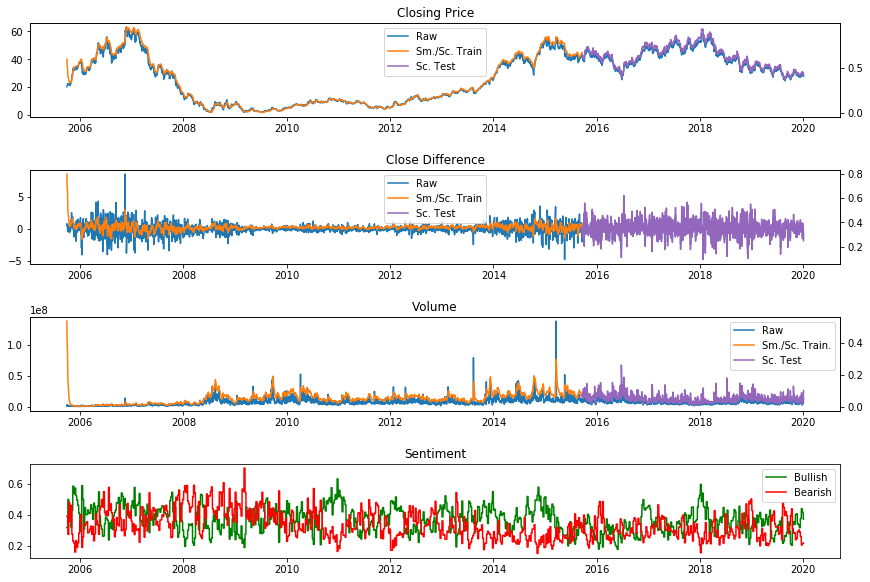

In [43]:
# Hyperparameter Definition
reload_gen()

EMA = 0.0
gamma = 0.2
train_percent = 0.7
val_percent = 0.0

master_df_train, master_df_val, master_df_test = preprocessing.splitter(master_df, train_percent, val_percent)

master_df_train_exclude = pd.DataFrame({'Date': master_df_train['Date'], 'Adj Close': master_df_train['Adj Close'], 
                                'Ticker': master_df_train['Ticker']})

master_df_val_exclude = pd.DataFrame({'Date': master_df_val['Date'], 'Adj Close': master_df_val['Adj Close'], 
                               'Ticker': master_df_val['Ticker']})

master_df_test_exclude = pd.DataFrame({'Date': master_df_test['Date'], 'Adj Close': master_df_test['Adj Close'], 
                               'Ticker': master_df_test['Ticker']})

master_df_train = master_df_train.drop(['Date', 'Adj Close', 'Ticker'], axis = 1)
master_df_val = master_df_val.drop(['Date', 'Adj Close', 'Ticker'], axis = 1)
master_df_test = master_df_test.drop(['Date', 'Adj Close', 'Ticker'], axis = 1)

master_df_train_sm_sc, master_df_val_sm_sc, master_df_test_sm_sc = preprocessing.smoother_scaler(master_df_train, master_df_val, master_df_test, EMA, gamma)

for col in master_df_train_exclude.columns:
    master_df_train_sm_sc[col] = master_df_train_exclude[col].values

for col in master_df_val_exclude.columns:
    master_df_val_sm_sc[col] = master_df_val_exclude[col].values
    
for col in master_df_test_exclude.columns:
    master_df_test_sm_sc[col] = master_df_test_exclude[col].values

%matplotlib inline
plt.figure(1)
fig, axs = plt.subplots(4, 1, figsize=(12,8))

# Plot Close Price Data
raw_close_line = axs[0].plot(master_df['Date'], master_df['Close'], label = "Raw", c = 'tab:blue')
lns0 = raw_close_line 

axs01 = axs[0].twinx()  
sm_sc_train_close_line = axs01.plot(master_df_train_sm_sc['Date'], master_df_train_sm_sc['Close'], 
                                       label = "Sm./Sc. Train", c = 'tab:orange')
lns0 += sm_sc_train_close_line
if not master_df_val_sm_sc.empty: 
    sm_sc_val_close_line = axs01.plot(master_df_val_sm_sc['Date'], master_df_val_sm_sc['Close'], 
                                           label = "Sc. Val.", c = 'tab:red')
    lns0 += sm_sc_val_close_line
    
sm_sc_test_close_line = axs01.plot(master_df_test_sm_sc['Date'], master_df_test_sm_sc['Close'], 
                                       label = "Sc. Test", c = 'tab:purple')
lns0 += sm_sc_test_close_line

# Plot Closing Difference Data
raw_close_diff_line = axs[1].plot(master_df['Date'], master_df['Close_diff_1'],
                                    label = "Raw", c = 'tab:blue')
lns1 = raw_close_diff_line

axs11 = axs[1].twinx()
sm_sc_train_close_diff_line = axs11.plot(master_df_train_sm_sc['Date'], master_df_train_sm_sc['Close_diff_1'],
                                        label = "Sm./Sc. Train", c = "tab:orange")
lns1 += sm_sc_train_close_diff_line
if not master_df_val_sm_sc.empty:
    sm_sc_val_close_diff_line = axs11.plot(master_df_val_sm_sc['Date'], master_df_val_sm_sc['Close_diff_1'],
                                          label = "Sc. Val.", c = 'tab:red')
    lns1 += sm_sc_val_close_diff_line

sm_sc_test_close_diff_line = axs11.plot(master_df_test_sm_sc['Date'], master_df_test_sm_sc['Close_diff_1'],
                                       label = "Sc. Test", c = 'tab:purple')

lns1 += sm_sc_test_close_diff_line

# Plot Volume Data
raw_vol_line = axs[2].plot(master_df['Date'], master_df['Volume'], label = "Raw", c = 'tab:blue')
lns2 = raw_vol_line

axs22 = axs[2].twinx()
sm_sc_train_vol_line = axs22.plot(master_df_train_sm_sc['Date'], master_df_train_sm_sc['Volume'], 
           label = "Sm./Sc. Train.", c = 'tab:orange')
lns2 += sm_sc_train_vol_line

if not master_df_val_sm_sc.empty:
    sm_sc_val_vol_line = axs22.plot(master_df_val_sm_sc['Date'], master_df_val_sm_sc['Volume'], 
               label = "Sc. Vol.", c = 'tab:red')
    lns2 += sm_sc_val_vol_line

sm_sc_test_vol_line = axs22.plot(master_df_test_sm_sc['Date'], master_df_test_sm_sc['Volume'], 
           label = "Sc. Test", c = 'tab:purple')
lns2 += sm_sc_test_vol_line

# Plot Sentiment Data
raw_bull_line = axs[3].plot(master_df['Date'], master_df['Bullish'], 
            label = "Bullish", color='g')
raw_bear_line = axs[3].plot(master_df['Date'], master_df['Bearish'], 
            label = "Bearish", color='r')

axs[0].set_title("Closing Price")
axs[1].set_title("Close Difference")
axs[2].set_title("Volume")
axs[3].set_title("Sentiment")

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)

labs0 = [l.get_label() for l in lns0]
axs[0].legend(lns0, labs0, loc=0)

labs1 = [l.get_label() for l in lns1]
axs[1].legend(lns1, labs1, loc=0)

labs2 = [l.get_label() for l in lns2]
axs[2].legend(lns2, labs2, loc=0)

axs[3].legend(['Bullish', 'Bearish'])

### Preparing to Run NN

In [79]:
'''
Hyperparameter Definition
'''
reload_gen()

batch_size = 2
dropout = 0.1
epochs = 10
seq_length = 60
''''''

master_data_training = master_df_train_sm_sc.drop(['Date', 'Adj Close', 'Ticker'], axis = 1)
master_val_training = master_df_val_sm_sc.drop(['Date', 'Adj Close', 'Ticker'], axis = 1)
master_data_testing = master_df_test_sm_sc.drop(['Date', 'Adj Close', 'Ticker'], axis = 1)

X_train, y_train = timeseries_preprocessing.ltsm_sequence_generator(master_data_training, seq_length, 'Close_diff_1')
X_val, y_val = timeseries_preprocessing.ltsm_sequence_generator(master_val_training, seq_length, 'Close_diff_1')

### Model Building

In [81]:
reload_gen()

model = network_construction.build_NN(X_train, batch_size, dropout)
model = network_construction.add_Optimizer(model)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 60, 64)            21248     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 120,193
Trainable params: 120,193
Non-trainable params: 0
_________________________________________________________________


### Model Training

In [82]:
model, history = network_training.train_Model(model, X_train, y_train, X_val, y_val, 
                                              epochs, batch_size, early_stopping = 0)



Train on 2466 samples
Epoch 1/10
2466/2466 [==============================] - 80s 32ms/sample - loss: 0.0013
Epoch 2/10
2466/2466 [==============================] - 76s 31ms/sample - loss: 6.8773e-04
Epoch 3/10
2466/2466 [==============================] - 75s 30ms/sample - loss: 5.9975e-04
Epoch 4/10
2466/2466 [==============================] - 74s 30ms/sample - loss: 5.5285e-04s 
Epoch 5/10
2466/2466 [==============================] - 73s 30ms/sample - loss: 5.1744e-04
Epoch 6/10
2466/2466 [==============================] - 77s 31ms/sample - loss: 4.7393e-04
Epoch 7/10
2466/2466 [==============================] - 78s 32ms/sample - loss: 4.4880e-04
Epoch 8/10
2466/2466 [==============================] - 75s 30ms/sample - loss: 3.6677e-04
Epoch 9/10
2466/2466 [==============================] - 73s 30ms/sample - loss: 3.2742e-04s - loss: 3.2699 - ETA: 0s - loss: - ETA: 0s - loss: 3.2605e-0 - ETA: 0s - loss: 3.2580e
Epoch 10/10
2466/2466 [==============================] - 73s 30ms/sample 

Text(0, 0.5, 'Loss')

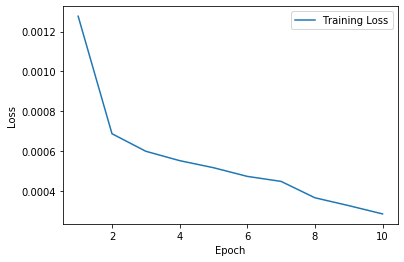

In [83]:
training_loss = history.history['loss']
epoch_count = range(1, len(training_loss) + 1)
plt.plot(epoch_count, training_loss)

if 'val_loss' in history.history.keys():
    test_loss = history.history['val_loss']
    plt.plot(epoch_count, test_loss)
    plt.legend(['Training Loss', 'Val Loss'])
else:
    plt.legend(['Training Loss'])
    
plt.xlabel('Epoch')
plt.ylabel('Loss')

### Save Model

In [84]:
save_dir = r'C:\Users\Mark\Documents\Trading_Documentation\Models_Saved'
model_name = r'\A007'
save_path = save_dir + model_name

network_construction.save_model(model, save_path)

INFO:tensorflow:Assets written to: C:\Users\Mark\Documents\Trading_Documentation\Models_Saved\A007\assets


### Model Evaluation

              precision    recall  f1-score   support

        -1.0       0.50      0.97      0.66       538
         0.0       0.00      0.00      0.00        10
         1.0       0.58      0.04      0.07       534

    accuracy                           0.50      1082
   macro avg       0.36      0.34      0.24      1082
weighted avg       0.54      0.50      0.36      1082



C:\Users\Mark\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<Figure size 432x288 with 0 Axes>

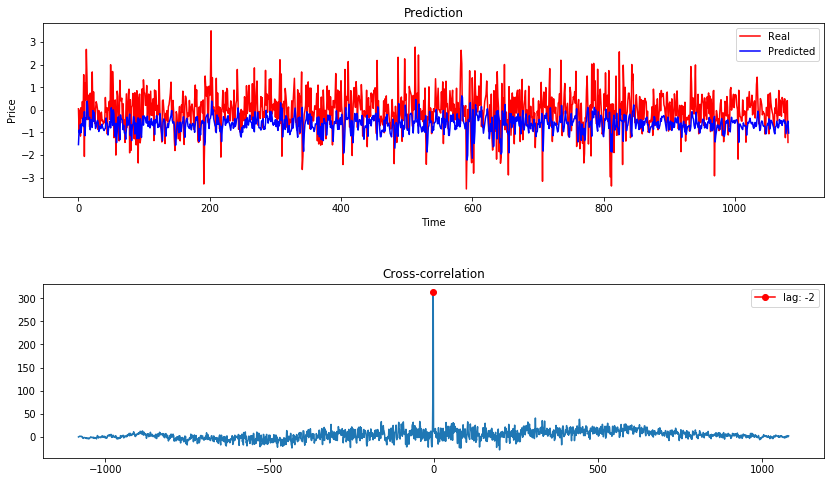

In [85]:
%matplotlib inline

reload_gen()
close_pred, fig = network_evaluation.evaluate_performance(model, master_df_train, master_df_test, 
                                   master_data_training, master_data_testing, seq_length, 'Close_diff_1')


In [86]:
'''
%matplotlib inline

reload_gen() 

single_day_percentages, single_day_pred_changes, cumulative_percentages, sum_percent_trading_error = trading_evaluation.evaluate_model_AA001_day_ahead(
    close_pred, master_df_test['Close_diff_1'].values, 
    master_df_train['Close_diff_1'].values, 0.1)

print("sum_percent_trading_error: ", sum_percent_trading_error)
'''

'\n%matplotlib inline\n\nreload_gen() \n\nsingle_day_percentages, single_day_pred_changes, cumulative_percentages, sum_percent_trading_error = trading_evaluation.evaluate_model_AA001_day_ahead(\n    close_pred, master_df_test[\'Close_diff_1\'].values, \n    master_df_train[\'Close_diff_1\'].values, 0.1)\n\nprint("sum_percent_trading_error: ", sum_percent_trading_error)\n'

### Model and Hyperparameter Sweep 
***

_Data Preprocessing Parameters to Sweep:_
- Smoothing gamma

_Hyperparameters to Sweep:_ 
- seq_length 
- batch_size

_Model Architectural Parameters:_
- Number of LTSM layers
- Number of Dense layers
- Units of LTSM and Dense layers
- Ordering of LTSM and Dense layers
- Optimizer
- Loss function
- Activation function
- Dropout

_Information to Record:_
- Loss vs. Epoch
- evaluate_performance plot
- evaluate_model_AA001_day_ahead plot

In [ ]:
reload_gen()

# Static Metrics
EMA = 0.0
gamma = 0.9
train_percent = 0.7
val_percent = 0.0

seq_length = 60
batch_size = 1
dropout = 0.1
epochs = 15
activation_case = 0

# Data Preprocessing Parameters to Sweep:
gamma_sweep_arr = np.logspace(np.log10(0.1), np.log10(1), num = 10, endpoint = True, base = 10.0)

# Hyperparameters to Sweep: 
batch_size_sweep_arr = np.array([1, 5, 10, 50])
seq_length_sweep_arr = np.array([5, 10, 50, 100, 150])

# Model Architectural Parameters:
dropout_sweep_arr = np.array([0.1, 0.2, 0.3]) # Later replace with for loop --> multiprocessing
activation_case_sweep_arr = np.array([0, 1, 2, 3]) # Later replace with for loop --> multiprocessing

fl_cases = [0, 1]
sl_cases = [0, 1]
tl_cases = [0, 1, 2]
layer_cases = np.array(np.meshgrid(fl_cases, sl_cases,tl_cases)).T.reshape(-1, 3)

flu_cases = [0, 1, 2, 3, 4]
slu_cases = [0, 1, 2, 3, 4]
tlu_cases = [0, 1, 2, 3, 4]
units_cases = np.array(np.meshgrid(flu_cases, slu_cases,tlu_cases)).T.reshape(-1, 3)

        
# Data Preprocessing
master_df_train, master_df_val, master_df_test = preprocessing.splitter(master_df, train_percent, val_percent)

master_df_train_exclude = pd.DataFrame({'Date': master_df_train['Date'], 'Adj Close': master_df_train['Adj Close'], 
                                        'Ticker': master_df_train['Ticker']})

master_df_val_exclude = pd.DataFrame({'Date': master_df_val['Date'], 'Adj Close': master_df_val['Adj Close'], 
                                      'Ticker': master_df_val['Ticker']})

master_df_test_exclude = pd.DataFrame({'Date': master_df_test['Date'], 'Adj Close': master_df_test['Adj Close'], 
                                       'Ticker': master_df_test['Ticker']})

master_df_train = master_df_train.drop(['Date', 'Adj Close', 'Ticker'], axis = 1)
master_df_val = master_df_val.drop(['Date', 'Adj Close', 'Ticker'], axis = 1)
master_df_test = master_df_test.drop(['Date', 'Adj Close', 'Ticker'], axis = 1)

master_df_train_sm_sc, master_df_val_sm_sc, master_df_test_sm_sc = preprocessing.smoother_scaler(master_df_train, master_df_val, master_df_test, EMA, gamma)

master_data_training = master_df_train_sm_sc
master_data_val = master_df_val_sm_sc
master_data_testing = master_df_test_sm_sc

X_train, y_train = timeseries_preprocessing.ltsm_sequence_generator(master_data_training, seq_length)    
X_val, y_val = timeseries_preprocessing.ltsm_sequence_generator(master_data_val, seq_length)    

yy_train = master_df_train['Close'].values    
yy_test = master_df_test['Close'].values

model_count = 0 
xlsx_row = 1
xlsx_col = 0 

for layer_case in layer_cases:
    for units_case in units_cases:
        model = network_construction.model_mixer(X_train, 
                                         batch_size, 
                                         dropout, 
                                         activation_case, 
                                         layer_case,
                                         units_case)
        model = network_construction.add_Optimizer(model)
        model, history = network_training.train_Model(model, X_train, y_train, X_val, y_val, 
                                                      epochs, batch_size, early_stopping = 0)
        
        # Get training and test loss histories
        training_loss = history.history['loss']
        test_loss = history.history['val_loss']
        epoch_count = range(1, len(training_loss) + 1)
        
        plt.figure()
        plt.plot(epoch_count, training_loss)
        plt.plot(epoch_count, test_loss)
        plt.legend(['Training Loss', 'Val Loss'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.savefig('logs/loss_v_epoch_model_{}.png'.format(model_count))
        
        min_training_loss = np.array(training_loss).min()
        
        close_pred, close_plt = network_evaluation.evaluate_performance(model, master_df_train, master_df_test, 
                                   master_data_training, master_data_testing, seq_length)
        
        close_plt.savefig('logs/close_pred_model_{}.png'.format(model_count))

        correct_direction_percent = trading_evaluation.direction_evaluation(close_pred, yy_test, yy_train)
        
        with open('logs/log.csv', 'a', newline='') as csv_file:
            writer = csv.writer(csv_file)
            writer.writerow([layer_case[0], layer_case[1], layer_case[2], 
                             units_case[0], units_case[1], units_case[2],
                            gamma, seq_length, batch_size, dropout,
                             min_training_loss, correct_direction_percent])
        
        model_count += 1


In [ ]:
A002 = load_model('../Trading_Documentation/Models_Saved/A002')
A002.summary()